In [1]:
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')


import nustar_dem_prep as nu
import all_nu_analysis as ana
import nustar_utilities as nuutil
import region_fitting as rf

import pickle
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u

import sunpy.map
import glob
from astropy.io import fits
import nustar_pysolar as nustar

from astropy.coordinates import SkyCoord
from astropy import coordinates as coord
from regions import CircleSkyRegion

In [2]:
all_targets_file_wnew='/Users/jmdunca2/do-dem/reference_files/all_targets_postghost_postshut.pickle'
with open(all_targets_file_wnew, 'rb') as f:
    all_targets = pickle.load(f)

ONLY DID IT FOR FIRST REGION
ONLY DID IT FOR FIRST REGION
ONLY DID IT FOR FIRST REGION
Using input regfile:
/Users/jmdunca2/do-dem/DEM_folders//initial_dem_11dec22_2/ghost_ref_20801017001_A.reg
Using grades 0-4 NuSTAR events.
ARF File:  ['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_11dec22_2/23-54-39_00-55-44/nu20801017001A06_0_4_p_sr.arf']
RMF File:  ['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_11dec22_2/23-54-39_00-55-44/nu20801017001A06_0_4_p_sr.rmf']
PHA File:  ['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_11dec22_2/23-54-39_00-55-44/nu20801017001A06_0_4_p_sr.pha']
ARF File:  ['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_11dec22_2/23-54-39_00-55-44/nu20801017001A06_21_24_p_sr.arf']
RMF File:  ['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_11dec22_2/23-54-39_00-55-44/nu20801017001A06_21_24_p_sr.rmf']
PHA File:  ['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_11dec22_2/23-54-39_00-55-44/nu20801017001A06_21_24_p_sr.pha']

For NuSTAR area, using region in:  /Users

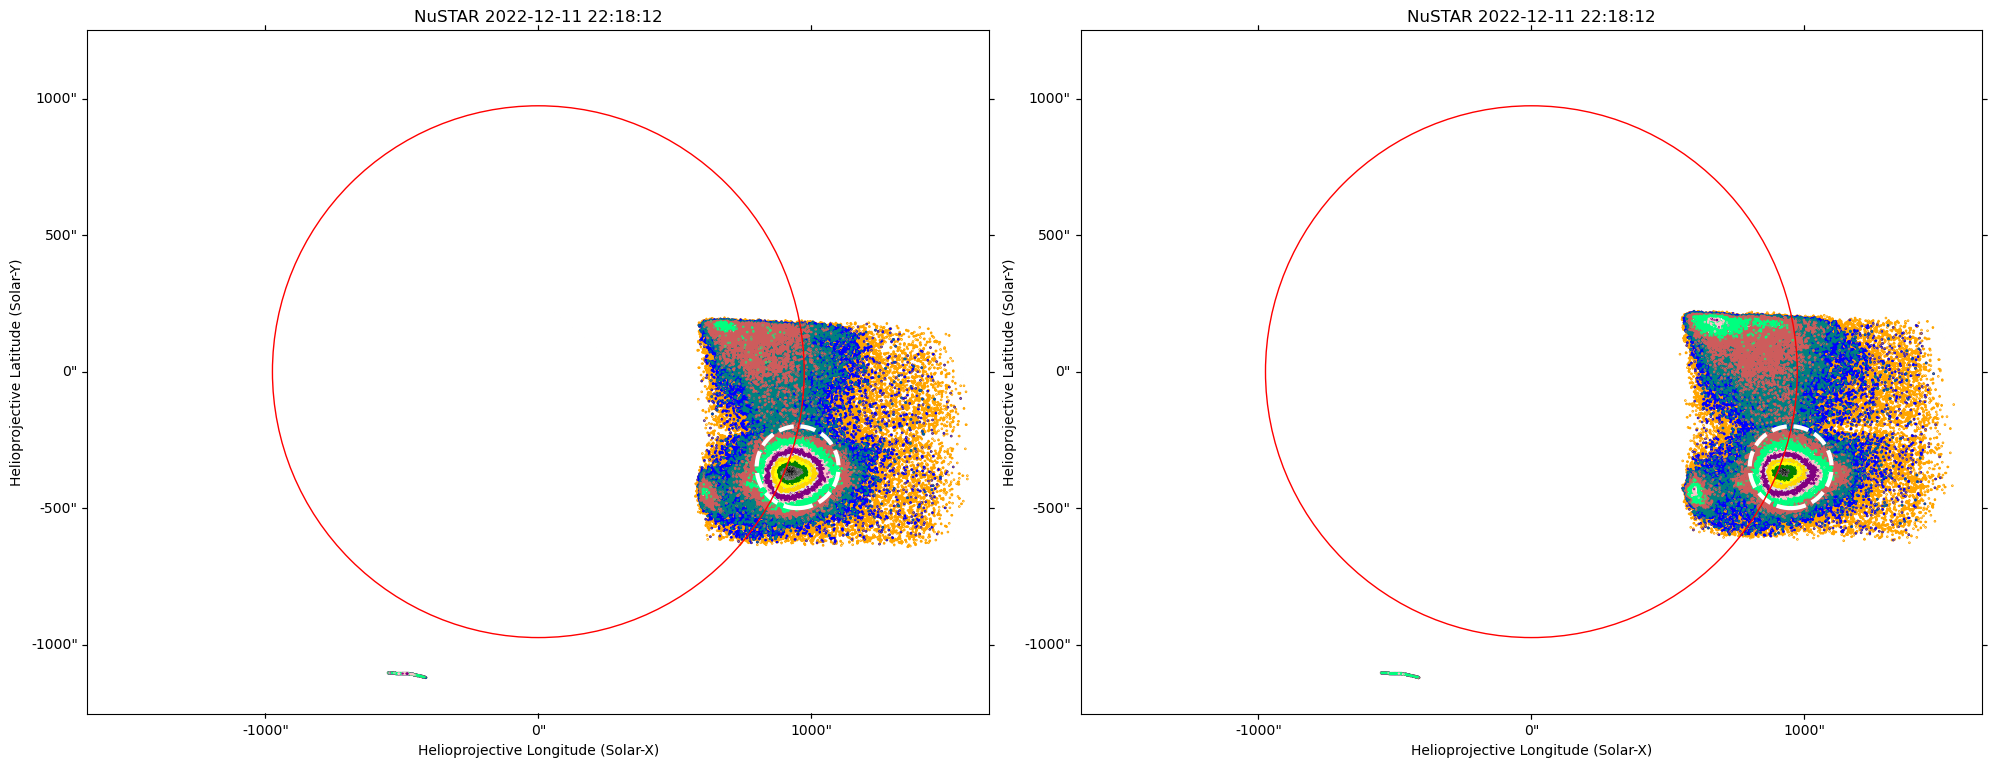

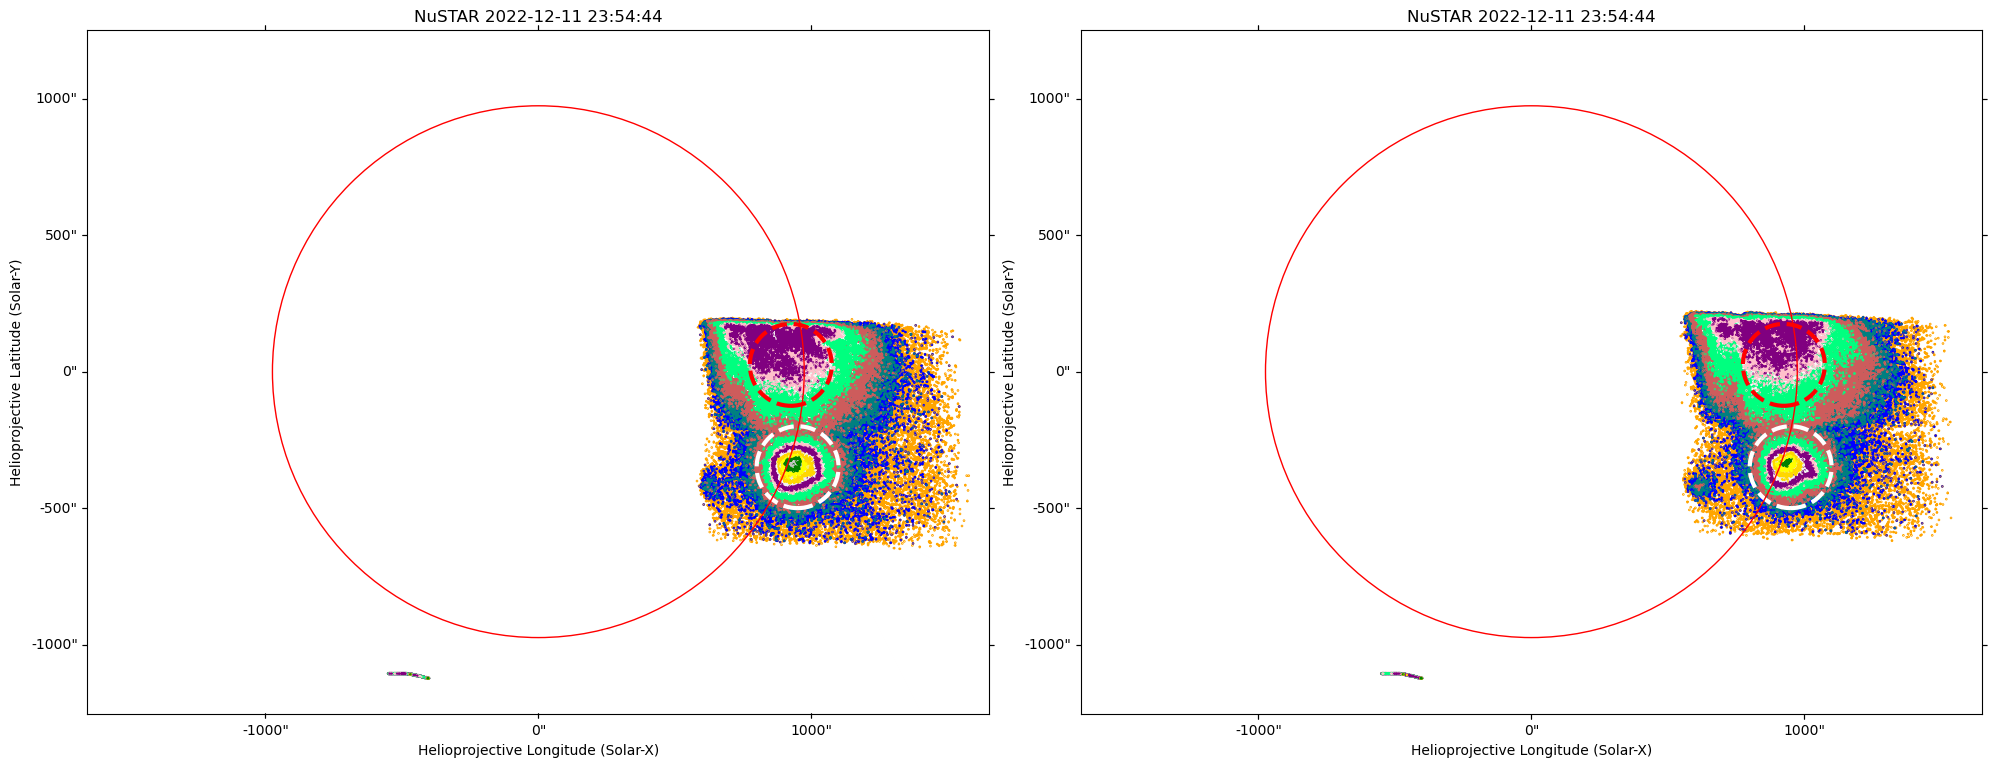

In [3]:
def make_ghost_region(key, file, show=False, gorbit=0, gregion={}, 
                                 eng_tr = [[2.5, 3.5], [3.5, 6.], [6., 10.]],
                                 go_ahead=False, write_new_file=True):
    """
    For a given observation, makes a ghost ray plot for every orbit. When you've picked which orbit and which
    region will be the ghost ray reference region, use the gorbit and gregion commands to select it. The region 
    will be plotted and saved for later use. 
    
    """
    contourlevs = [1,2,3,5,10,20,25,50,75,99]
    colors = ['orange', 'blue', 'teal', 'indianred', 'springgreen', 'pink', 'purple', 'gold', 'yellow', 'green']

    
    with open(file, 'rb') as f:
        data = pickle.load(f)
    
    ARDict = data[key]
    
    id_dirs = ARDict['datapaths']
    obsids = ARDict['obsids']
    working_dir = ARDict['working_dir']
    #prepped_aia_dir = ARDict['prepped_aia']
    method=ARDict['method']

    
    
    orbit=0
    for id in id_dirs:
        sunpos = glob.glob(id+'/event_cl/*sunpos*.evt')
        count=1

        fig = plt.figure(figsize=(20,8), tight_layout = {'pad': 1})

        for s in sunpos:
            with fits.open(s, ignore_missing_simple=True) as hdu:
                hdr = hdu[1].header
            time0 = nuutil.convert_nustar_time(hdr['TSTART'])
            time1 = nuutil.convert_nustar_time(hdr['TSTOP'])

            with fits.open(s) as hdu:
                evt_data = hdu[1].data
                hdr = hdu[1].header

            cleanevt = nustar.filter.event_filter(evt_data, energy_low=2.5, energy_high=15.,
                                             no_bad_pix_filter=True, no_grade_filter=True)
        
            nustar_map = nustar.map.make_sunpy(cleanevt, hdr)
            bl = SkyCoord( *(-1650, -1250)*u.arcsec, frame=nustar_map.coordinate_frame)
            tr = SkyCoord( *(1650, 1250)*u.arcsec, frame=nustar_map.coordinate_frame)
            submap = nustar_map.submap(bottom_left=bl, top_right=tr)
            ax = fig.add_subplot(1,2,count, projection=submap, aspect='auto')#, sharex=True, sharey=True)
            submap.plot(axes=ax, cmap='Greys')#
            submap.draw_contours(contourlevs, colors=colors[0:len(contourlevs)], axes=ax) #axs[count])
            submap.draw_limb(color='red', axes=ax) #axs[count])
            count+=1

            fpm=s.split('.')[0][-13]
            obsid=s.split('.')[0][-24:-13]
            region_dir=working_dir
            if method == 'fit':
                regfile = region_dir+'gauss_cen_'+obsid+'_'+fpm+'_'+'single.reg'
            if method == 'input':
                print('ONLY DID IT FOR FIRST REGION')
                regfile = region_dir+'gauss_cen_'+obsid+'_'+fpm+'_user_input_0.reg'
            if method == 'double':
                print('ONLY DID IT FOR FIRST REGION')
                regfile = region_dir+'gauss_cen_'+obsid+'_'+fpm+'_0.reg'
            offset, rad = rf.read_regfile(regfile, time0, time1, 'hourangle')
            
            center = SkyCoord( *(offset[0].value, offset[1].value)*u.arcsec, frame=submap.coordinate_frame)
            region = CircleSkyRegion(
                    center = center,
                    radius = rad
                )
        
            #print(offset, rad)
            
            og_region = region.to_pixel(submap.wcs)
            og_region.plot(axes=ax, color='white', ls='--', lw=3, zorder=5)

            if orbit==gorbit and gregion:
                if write_new_file:
                    center = SkyCoord( *(gregion['centerx'], gregion['centery'])*u.arcsec, frame=submap.coordinate_frame)
                    region = CircleSkyRegion(
                            center = center,
                            radius = gregion['radius']*u.arcsec
                        )
                    #print(offset, rad)
                
                    og_region = region.to_pixel(submap.wcs)
                    og_region.plot(axes=ax, color='red', ls='--', lw=3, zorder=5)
                    
                    midway = time0 + (time1-time0).to(u.s).value/2*u.s
                    newfile=working_dir+'ghost_ref_'+obsid+'_'+fpm
                    rf.write_regfile('starter_region.reg', midway, region, newfile=newfile) 
                else:
                    newfile=working_dir+'ghost_ref_'+obsid+'_'+fpm

                    offset, rad = rf.read_regfile(newfile+'.reg', time0, time1, 'hourangle')
                    
                    center = SkyCoord( *(offset[0].value, offset[1].value)*u.arcsec, frame=submap.coordinate_frame)
                    region = CircleSkyRegion(
                            center = center,
                            radius = rad
                        )
                    og_region = region.to_pixel(submap.wcs)
                    og_region.plot(axes=ax, color='red', ls='--', lw=3, zorder=5)

                if go_ahead:
                    time = [time0, time1]
                    nustar_path = working_dir
                    gtifile=id+'event_cl/nu'+obsid+'A06_gti.fits'
                    
                    res = nu.load_nustar(time, eng_tr, nustar_path, fpm, 
                                   make_nustar=True, gtifile=gtifile, datapath=id, regfile=newfile+'.reg', 
                                    edit_regfile=False, compare_fpm=False, combine_fpm=False, actual_total_counts=True, centroid_region=False,
                                       use_fit_regfile=False, clobber=False, default_err=0.2, pile_up_corr=True, special_pha='',
                                       adjacent_grades=True, nuradius=150, path_to_dodem=path_to_dodem, shush=False,
                                       twogauss=False, onegauss=False, direction='', guess=[], guess2=[], return_for_pile_up_figure=False,
                                       energy_percents=False)
                    
                    rate, erate, nutrs, tresp, logt, fpm, atc = res
                    
                    ARDict['Ghost_Ray_Rate_'+fpm] = rate
                

        if orbit==gorbit and gregion:  
            plt.savefig(working_dir+'ghost_plot_efilter2.5-15_'+obsids[orbit]+'ghost_ref.png')
        else:
            plt.savefig(working_dir+'ghost_plot_efilter2.5-15_'+obsids[orbit]+'.png')
        orbit+=1


    data[key].update(ARDict)
    with open(file, 'wb') as f:
         # Pickle the 'data' dictionary using the highest protocol available.
         pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)  



key='11-dec-22_2'

#If single gaussian fit region:
#Currently the way I modified this, you need to have both the plot options true to write the single gauss regions to a file.
#ana.single_gauss_prep(key, all_targets_file_wnew, plot=True, write_gauss_regions=True,
#                     plotgaussregions=True)

gregion = {'centerx': 925.0, 'centery': 25.0, 'radius': 150.0}
gorbit=1
#Get the region correct before switching to True or you'll waste a lot of time.
go_ahead=True

#make sure you do this with the same energy ranges you want for the DEM.
eng_tr = [[2.5, 3.5], [3.5, 6.], [6., 10.]]
make_ghost_region(key, all_targets_file_wnew, gregion=gregion, gorbit=gorbit, go_ahead=go_ahead, write_new_file=False)



In [46]:
#For when you need to use a ghost ray rate from a different key
with open(all_targets_file_wnew, 'rb') as f:
    all_targets = pickle.load(f)
    
#recievers = ['19-nov-21', '20-nov-21']
#donor='17-nov-21_2'

# recievers = ['22-nov-21_1']
# donor='21-nov-21'

recievers = ['24-feb-22']
donor='25-feb-22'

for kk in recievers:
    all_targets[kk]['Ghost_Ray_Rate_A'] = all_targets[donor]['Ghost_Ray_Rate_A']
    all_targets[kk]['Ghost_Ray_Rate_B'] = all_targets[donor]['Ghost_Ray_Rate_B']

with open(all_targets_file_wnew, 'wb') as f:
     # Pickle the 'data' dictionary using the highest protocol available.
     pickle.dump(all_targets, f, pickle.HIGHEST_PROTOCOL)

In [45]:
with open(all_targets_file_wnew, 'rb') as f:
    all_targets = pickle.load(f)
    
key='25-feb-22'
all_targets[key]

{'NOAA_ARID': ['AR12955'],
 'HARP': [8032],
 'datapaths': ['/Users/jmdunca2/nustar/feb-2022/20622002001/',
  '/Users/jmdunca2/nustar/feb-2022/20622003001/',
  '/Users/jmdunca2/nustar/feb-2022/20622004001/'],
 'obsids': ['20622002001', '20622003001', '20622004001'],
 'working_dir': '/Users/jmdunca2/do-dem/DEM_folders//initial_dem_25feb22/',
 'loc': ['disk'],
 'hale_class': [''],
 'method': 'input',
 'notes': '',
 'goes_satellite': 16,
 'orbit durations': [<Quantity 59.51666667 min>,
  <Quantity 59.53333333 min>,
  <Quantity 59.53333332 min>],
 'total duration': <Quantity 178.58333332 min>,
 'total livetime': <Quantity 2.24198519 min>,
 'Region Coordinates': [{'centerx': -280.0, 'centery': 480.0, 'radius': 150.0},
  {'centerx': -450.0, 'centery': 280.0, 'radius': 150.0},
  {'centerx': -650.0, 'centery': 450.0, 'radius': 150.0}],
 'region_stats': [[5, 7, 15], [4, 7, 20], [4, 8, 21]],
 'directories': ['/Users/jmdunca2/do-dem/DEM_folders//initial_dem_25feb22/region_0/',
  '/Users/jmdunca2/d